# Homework 3. Кошелев Александр

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tqdm.auto import tqdm

# Load data

In [4]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xvf facades.tar.gz

--2021-11-28 14:32:14--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.2’

facades.tar.gz.2    100%[===================>]  28.77M   284KB/s    in 93s     

2021-11-28 14:33:48 (317 KB/s) - ‘facades.tar.gz.2’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facades

# Prepare data

In [5]:
!ls 

drive  facades	facades.tar.gz	facades.tar.gz.1  facades.tar.gz.2  sample_data


In [4]:
class FacsdesDataset(torch.utils.data.Dataset):
    
    def __init__(self, folder='facades/train'):
        self.folder = folder
        self.files = glob(self.folder + '/*.jpg');
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])
        
    def __getitem__(self, idx):
        imgs = Image.open(self.files[idx]).convert("RGB")
        img_from, img_to = imgs.crop((256, 0, 512, 256)), imgs.crop((0, 0, 256, 256))
        return self.transforms(img_from), self.transforms(img_to)   
        
    def __len__(self):
        return len(self.files)


train_dataset = FacsdesDataset(folder='facades/train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = FacsdesDataset(folder='facades/test')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=3, shuffle=False)

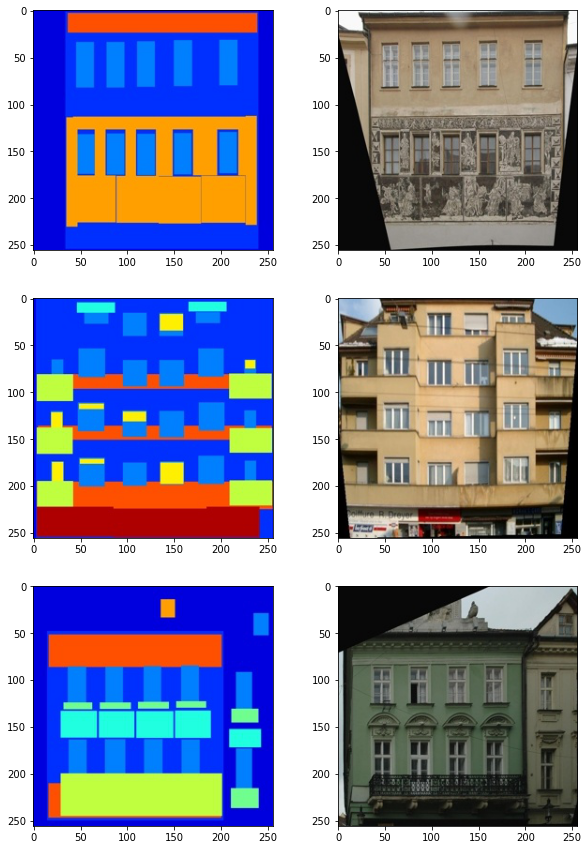

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    ax[i][0].imshow(train_dataset.__getitem__(i)[0].permute(1, 2, 0))
    ax[i][1].imshow(train_dataset.__getitem__(i)[1].permute(1, 2, 0))

# Pix2pix

In [6]:
import sys
sys.path.append("/content/drive/MyDrive/MADE/RL_DL_HW/rl_dl_made_homeworks/HW3")
from pix2pix.pix2pix import Pix2Pix
from utils import display_progress

In [7]:
pix2pix = Pix2Pix()

In [8]:
for e in range(80):
    pix2pix.generator.train()
    pix2pix.discriminator.train()
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False, position=0)
    for i, batch in pbar:
        disc_loss, generator_loss = pix2pix.train_step(batch)
        if (i + 1) % 10 == 0:
            print(f"Discriminator loss {disc_loss}")
            print(f"Generator loss {generator_loss}")
    
    if e % 5 == 0:
      pix2pix.generator.eval()
      for val_condition, val_img_real in val_dataloader:
          val_img_fake = pix2pix.generate(val_condition)
          display_progress(val_condition, val_img_fake, val_img_real)
          break

Output hidden; open in https://colab.research.google.com to view.

Поучим еще 40 эпох

In [9]:
for e in range(40):
    pix2pix.generator.train()
    pix2pix.discriminator.train()
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False, position=0)
    for i, batch in pbar:
        disc_loss, generator_loss = pix2pix.train_step(batch)
        if (i + 1) % 10 == 0:
            print(f"Discriminator loss {disc_loss}")
            print(f"Generator loss {generator_loss}")
    
    if e % 5 == 0:
      pix2pix.generator.eval()
      for val_condition, val_img_real in val_dataloader:
          val_img_fake = pix2pix.generate(val_condition)
          display_progress(val_condition, val_img_fake, val_img_real)
          break

Output hidden; open in https://colab.research.google.com to view.

In [11]:
with open("../../pix2pixgenerator.pth", "wb") as fp:
    torch.save(pix2pix.generator.state_dict(), fp)
with open("../../pix2pixdiscriminator.pth", "wb") as fp:
    torch.save(pix2pix.discriminator.state_dict(), fp)

In [13]:
pix2pix.generator.eval()
i = 0
for val_condition, val_img_real in val_dataloader:
    val_img_fake = pix2pix.generate(val_condition)
    display_progress(val_condition, val_img_fake, val_img_real)
    i += 1
    if i > 30:
      break

Output hidden; open in https://colab.research.google.com to view.

# end